# Produce Classifier — Quickstart Notebook

This notebook trains a model to predict the **`name`** of a fruit or vegetable from tabular attributes, using CSV files that live in **the same folder** as this notebook.

**It will:**
- Load `produce_train.csv`
- Build a preprocessing + model pipeline (OneHot for categoricals, StandardScaler for numerics, RandomForest classifier)
- Print a classification report
- Plot and save a confusion matrix image
- Save the trained pipeline to `model_quick.joblib`
- Score `produce_to_score.csv` and write `predictions_quick.csv` (with `prediction`, `probability`, `top3`)


In [6]:
# (Optional) install dependencies in this environment
%pip install -q pandas numpy scikit-learn joblib matplotlib

Note: you may need to restart the kernel to use updated packages.


In [7]:
from pathlib import Path

# === Filenames (all expected in the SAME directory as this notebook) ===
TRAIN_CSV = Path('produce_train.csv')       # training data with a 'name' column
SCORE_CSV = Path('produce_to_score.csv')    # rows to score (no 'name' column)
MODEL_OUT = Path('model_quick.joblib')      # trained model bundle
PRED_OUT  = Path('predictions_quick.csv')   # predictions for SCORE_CSV
CM_PNG    = Path('confusion_matrix.png')    # saved confusion matrix image
TARGET    = 'name'                           # the column to predict

# Basic existence checks (comment these if you want to run without files yet)
assert TRAIN_CSV.exists(), f"Missing {TRAIN_CSV.resolve()}"
assert SCORE_CSV.exists(), f"Missing {SCORE_CSV.resolve()}"
print('OK: found training and scoring CSVs in this folder.')

OK: found training and scoring CSVs in this folder.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# ---- Load training data
df = pd.read_csv(TRAIN_CSV)
y = df[TARGET]
X = df.drop(columns=[TARGET])

display(df.head())

,name,type,color,sweetness,crunchiness,juiciness,acidity,fiber_g,sugar_g,seeds,has_peel,typical_weight_g,is_tropical
0,blueberry,fruit,blue,6.7,2.4,5.9,2.8,2.46,9.56,few,False,1,False
1,potato,vegetable,brown,2.0,6.1,1.5,1.2,2.33,1.39,none,True,217,False
2,spinach,vegetable,green,0.9,2.4,6.7,1.6,1.04,0.57,none,False,33,False
3,watermelon,fruit,green,9.3,1.0,8.4,2.6,0.65,5.17,many,True,9339,False
4,mango,fruit,orange,7.9,1.7,7.9,3.8,2.82,13.23,few,True,163,True


In [9]:
# ---- Column type detection
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()
print('Numeric columns:', numeric_cols)
print('Categorical columns:', categorical_cols)

# ---- OneHotEncoder: support sklearn old/new API
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

pre = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', ohe, categorical_cols),
    ],
    remainder='drop'
)

clf = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)

pipe = Pipeline([('pre', pre), ('clf', clf)])

# ---- Train/validate split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

print('=== Classification report (validation) ===')
print(classification_report(y_val, y_pred))

Numeric columns: ['sweetness', 'crunchiness', 'juiciness', 'acidity', 'fiber_g', 'sugar_g', 'typical_weight_g']
Categorical columns: ['type', 'color', 'seeds', 'has_peel', 'is_tropical']
=== Classification report (validation) ===
              precision    recall  f1-score   support

       apple       0.92      1.00      0.96        24
      banana       1.00      1.00      1.00        24
 bell_pepper       0.95      1.00      0.97        18
   blueberry       1.00      1.00      1.00        24
      carrot       1.00      1.00      1.00        18
    cucumber       1.00      1.00      1.00        18
       grape       1.00      1.00      1.00        24
       mango       1.00      1.00      1.00        24
       onion       1.00      0.94      0.97        18
      orange       1.00      1.00      1.00        24
        pear       1.00      0.92      0.96        24
   pineapple       1.00      1.00      1.00        24
      potato       1.00      1.00      1.00        18
     spinach 

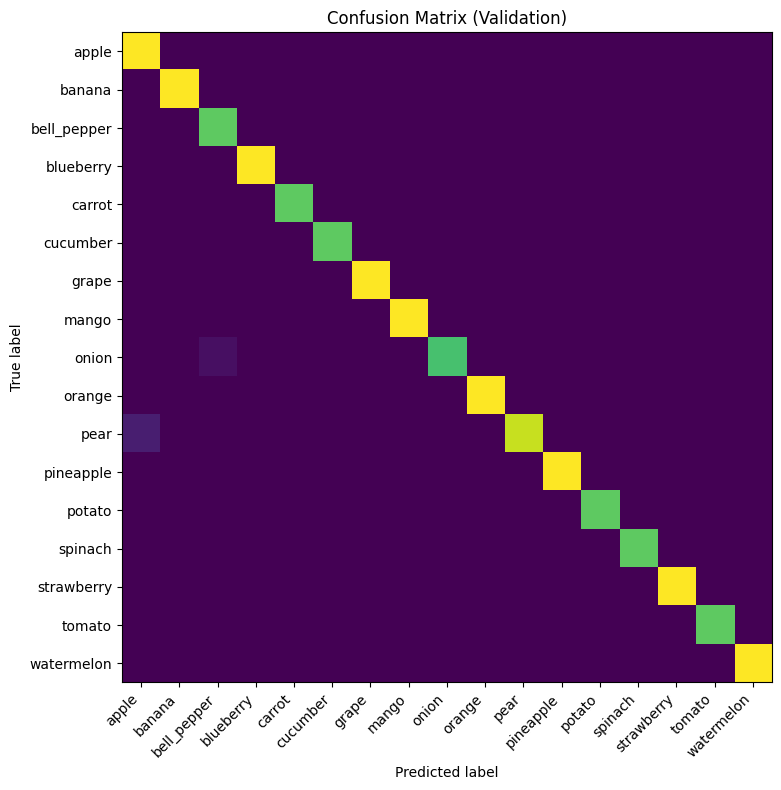

Saved confusion matrix -> /home/connor/Sophias_Mom/confusion_matrix.png


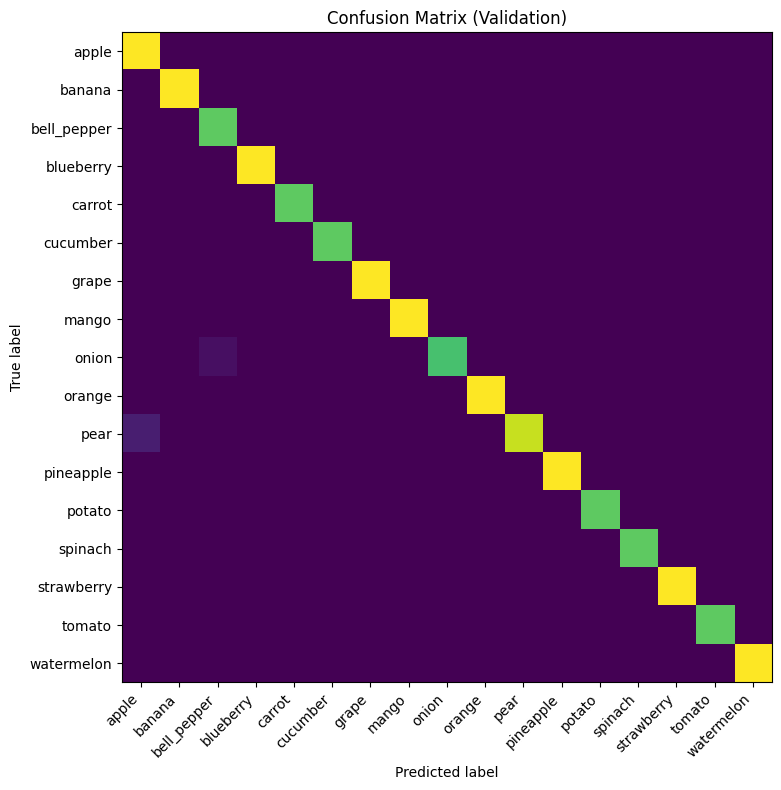

In [10]:
# ---- Confusion matrix
labels = sorted(y.unique().tolist())
cm = confusion_matrix(y_val, y_pred, labels=labels)

plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Validation)')
plt.xlabel('Predicted label'); plt.ylabel('True label')
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
plt.tight_layout()
plt.show()

# Save image to file
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Validation)')
plt.xlabel('Predicted label'); plt.ylabel('True label')
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
plt.tight_layout()
plt.savefig(CM_PNG.as_posix())
print('Saved confusion matrix ->', CM_PNG.resolve())

In [11]:
# ---- Save trained pipeline
dump({'pipeline': pipe, 'feature_order': X.columns.tolist()}, MODEL_OUT)
print('Saved model ->', MODEL_OUT.resolve())

Saved model -> /home/connor/Sophias_Mom/model_quick.joblib


In [12]:
# ---- Score new rows
to_score = pd.read_csv(SCORE_CSV)

# Align columns to match training-time features
expected = X.columns.tolist()
for col in expected:
    if col not in to_score.columns:
        to_score[col] = None
to_score = to_score[expected]

pred = pipe.predict(to_score)

out = to_score.copy()
out['prediction'] = pred

# Optionally add probabilities and top-3
proba = None
if hasattr(pipe, 'predict_proba'):
    try:
        proba = pipe.predict_proba(to_score)
        out['probability'] = proba.max(axis=1)
        top3_idx = np.argsort(-proba, axis=1)[:, :3]
        label_names = pipe.named_steps['clf'].classes_
        out['top3'] = [','.join(label_names[idx]) for idx in top3_idx]
    except Exception:
        pass

out.to_csv(PRED_OUT, index=False)
print('Wrote predictions ->', PRED_OUT.resolve())
out.head(12)

Wrote predictions -> /home/connor/Sophias_Mom/predictions_quick.csv


,type,color,sweetness,crunchiness,juiciness,acidity,fiber_g,sugar_g,seeds,has_peel,typical_weight_g,is_tropical,prediction,probability,top3
0,fruit,orange,7.8,2.5,9.0,3.2,2.28,17.61,few,True,154,True,mango,0.786667,"mango,banana,orange"
1,fruit,red,4.7,6.6,5.1,4.7,3.36,17.29,few,True,198,False,apple,0.973333,"apple,pear,bell_pepper"
2,vegetable,orange,4.6,7.0,1.9,2.1,2.23,5.85,none,False,71,False,carrot,1.000000,"carrot,apple,bell_pepper"
3,vegetable,orange,4.7,7.9,3.8,2.5,2.81,6.06,none,False,76,False,carrot,1.000000,"carrot,apple,bell_pepper"
4,fruit,red,6.7,5.4,6.9,4.7,4.58,21.17,few,True,192,False,apple,0.956667,"apple,pear,bell_pepper"
5,fruit,brown,6.8,2.1,8.3,3.0,0.46,6.76,many,True,9855,False,watermelon,0.923333,"watermelon,pineapple,pear"
6,vegetable,red,5.0,2.9,8.4,3.2,1.70,4.99,many,False,123,False,tomato,0.993333,"tomato,strawberry,apple"
7,vegetable,green,3.5,4.6,6.5,2.1,1.65,2.70,many,True,117,False,bell_pepper,1.000000,"bell_pepper,apple,banana"
8,fruit,red,5.3,2.7,8.0,4.2,2.17,6.31,many,False,21,False,strawberry,0.996667,"strawberry,tomato,apple"
9,fruit,brown,6.6,1.8,9.7,6.2,1.83,9.16,many,True,1018,True,pineapple,0.990000,"pineapple,orange,apple"
